# Notebook for training autoencoder models

Add your save directory name here.

In [ ]:
save_dir = 'SavedModels/CoordConv64' # put your own save dir name here

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch import optim
import torch.functional as F

In [3]:
DEVICE = torch.device('cuda')
torch.backends.cudnn.benchmark = True

In [4]:
from pylab import *

In [5]:
rcParams['figure.figsize']=18,7
rcParams['font.size']=15
rcParams['axes.grid']=True

style.use('dark_background')

In [6]:
from lines_curves_dataset import *
from modules import *
from autoenc_models import *
from pytorch_utils.train_utils import *
from pytorch_utils.updaters import *

## Get a dataset to test modules

In [7]:
from torchvision.transforms import *

In [8]:
batch_size = 64
batches_per_epoch = 200
validation_batches = batches_per_epoch//10

In [9]:
dataset_config = {
    'nlines_range':(0, 3), 
    'ncurves_range':(1, 4), 
    'nellipses_range':(0, 3), 
    'x_range':(0, 64), 
    'y_range':(0, 64), 
    'dilation_size_range':(3, 6), 
    'img_size':(64, 64), 
    'blur_sigma':0.7,
}

In [10]:
transform = Normalize([0.5],[0.5])

In [11]:
transform = None

In [12]:
dset = LinesCurvesDataset(imgs_per_epoch=batch_size*batches_per_epoch, 
                          **dataset_config, 
                          device=DEVICE,
                          transform=transform,)

In [13]:
val_dset = LinesCurvesDataset(imgs_per_epoch=batch_size*validation_batches, 
                          **dataset_config, 
                          device=DEVICE,
                          transform=transform,)

In [14]:
train_loader = DataLoader(dset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dset, batch_size = batch_size, shuffle=True)
loader = iter(train_loader)

torch.Size([1, 64, 64]) 1.0 0.0 0.33467864990234375


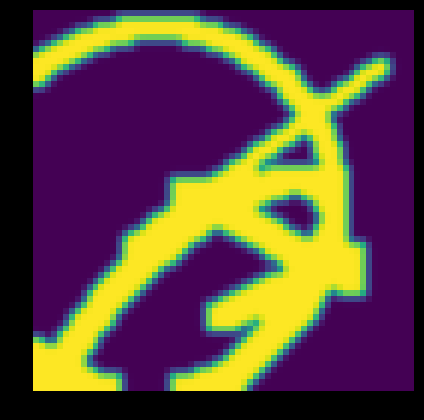

In [15]:
sample_inp = dset[0]
print(sample_inp.shape, sample_inp.max().item(), sample_inp.min().item(), sample_inp.mean().item())
axis('off')
imshow(sample_inp.cpu().numpy().transpose([1,2,0]).squeeze(), vmin=0, vmax=1)

# Instantiate the models

## coord conv with 64 hidden size

In [16]:
    encoder, decoder, autoencoder = coordconv_conv64(DEVICE)

Encoder has 944994 params
Decoder has 878428 params


# Functions for training

In [17]:
l1_lambda = 0.000 # for l1 activity regularization of encodings

In [18]:
def trainOnBatch(model,batch,optimizer):
    global l1_lambda
    
    # batch is tuple containing (tensor of images, tensor of labels)
    outputs, embeddings = model(batch, return_embedding=True) # forward pass
    
    # compute loss
    criterion = nn.MSELoss()
    loss = criterion(outputs,batch)

    l1_penalty = l1_lambda*torch.abs(embeddings).sum()
    
#     print(f"loss = {loss}, l1_penalty = {l1_penalty}")
    
    loss += l1_penalty
    
    # backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # compute and return metrics
    loss = loss.detach().cpu().numpy()
    return loss,

In [19]:
def callback(model, val_loader):
    with torch.no_grad(): # dont compute gradients
        criterion = nn.MSELoss()
        
        model = model.eval() # eval mode
        
        batches = len(val_loader)
        loss=0
        for batch in val_loader:
            outputs = model(batch)
            loss += criterion(outputs,batch)
        
        # find average loss over whole vaildation set
        loss/= batches
        
        model = model.train() # go back to train mode
        
        # return metrics
        return loss.cpu().numpy(),

# Running the train loop

In [20]:
trainer = Trainer(autoencoder, 
                  trainOnBatch, 
                  callback=callback,
                  save_dir=save_dir)

In [21]:
trainer.setup_metrics(batch_metric_names=['loss'], # trainOnBatch returns training loss
                      callback_metric_names=['val_loss'], # callback returns validation loss
                      batch_metric_updaters=[averager], # average the batch metrics over the epoch
                      save_name_metrics=['val_loss'], # Use the validation loss in checkpoint save names
                      fig_grid=(1,1), # 1 row, 1 cols
                      plot_grouping=[
                          ['loss','val_loss'], # first subplot for losses
                      ])

In [22]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01, weight_decay=0.00)

In [23]:
autoencoder.to(DEVICE).train();

## This cell starts the train loop

In [ ]:
metrics = trainer.loop(epochs=1000, 
                       train_loader=train_loader,
                       optimizer=optimizer, 
                       val_loader=val_loader,
                       update_interval=1,
                       old_metrics=None)